# ЛР1 — Первая сверточная нейронная сеть
---
*Зубарева Марина, РИМ-281226*

Построим первую сверточную с использование фреймворка Pytorch.

Используйте requirements курса для установки необходимых компонентов.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Pytorch был установлен через терминал в ОС Ubuntu (Ctrl+Alt+T) с помощью команды: *conda install pytorch torchvision -c pytorch*

Импортируем основные библиотеки для работы и выберем устройство для построения модели.
Если на компьютере имеет устройство с поддержкой CUDA, то оно будет использоваться для работы. В противном случае для работы будет использован процессор.
Переменная device указывает на используемое устройство.

Пока не углубляясь в способы обработки данных возьмем имеющийся датасет с рукописными цифрами MNIST из torchvision.datasets.
Данные представленны в виде PIL изображений и меток к каждому изображению (значения от 0 до 10 numpy).
В связи с тем, что pytorch не может работать напрямую с PIL изображениями и numpy массивами, данные необходимо пребразовать в тензоры.
Для этого используем transforms.ToTensors(). Помимо этого можно применять и другие трансформации, например проводить нормализацию данных.

In [2]:
T = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=T
                           )


test_data = datasets.MNIST('./mnist_data', 
                           download=True, 
                           train=False,
                           transform=T
                          )

Рассмотрим данные подробнее.
Выведем размеры данных и посмотрим распределения по каждой подвыборке.

In [3]:
print('Размер даннных изображений на тренировку: ', train_data.data.shape)
print('Размер меток на тренировку: ', train_data.targets.shape)

Размер даннных изображений на тренировку:  torch.Size([60000, 28, 28])
Размер меток на тренировку:  torch.Size([60000])


In [4]:
print('Размер даннных изображений на тестирование: ', test_data.data.shape)
print('Размер меток на тестирование: ', test_data.targets.shape)

Размер даннных изображений на тестирование:  torch.Size([10000, 28, 28])
Размер меток на тестирование:  torch.Size([10000])


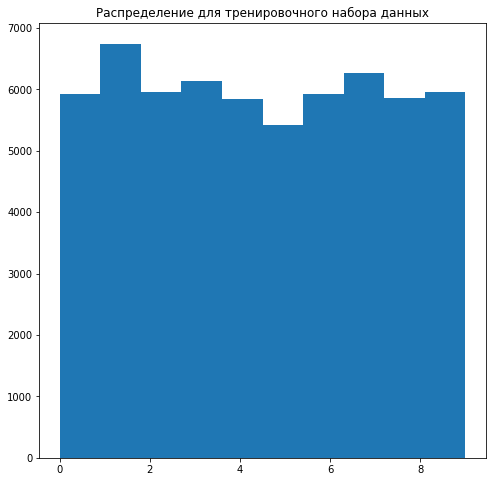

In [5]:
plt.figure (figsize =(8,8))
plt.title('Распределение для тренировочного набора данных')
plt.hist(train_data.targets);

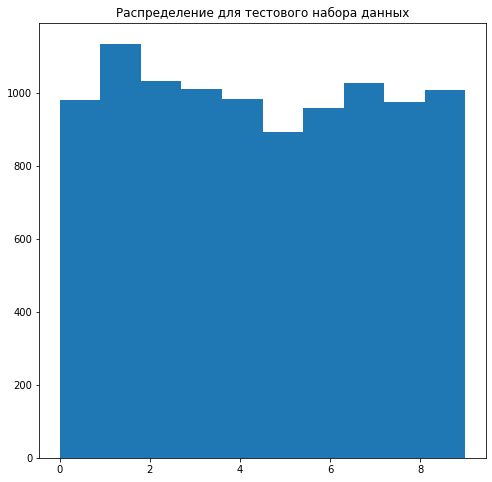

In [6]:
plt.figure (figsize =(8,8))
plt.title('Распределение для тестового набора данных')
plt.hist(test_data.targets);

Рассмотрим изображения с рукописными цифрами подробнее. Определим среднее, максимальное и минимальное значения, а также вычислим среднеквадратическое отклонение для тренировочного датасета. Полученные значения можно и нужно использовать для нормализации данных. Для нормализации данных следует использовать функцию transforms.Normalize().

In [7]:
num, height, width = np.array(train_data.data).shape
img_min = np.array(train_data.data).min()
img_max = np.array(train_data.data).max()
img_norm_mean = np.array(train_data.data, dtype=float).mean() / img_max
img_std = np.sqrt(np.sum((np.array(train_data.data) / img_max  - img_norm_mean) ** 2) / (num * height * width))
print(img_min, img_max, img_norm_mean, img_std)

0 255 0.1306604762738429 0.3081078038564622


In [8]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=8, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=8, 
                                          shuffle=False)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

tensor([4, 5, 6, 0, 3, 9, 1, 0])


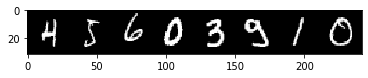

In [9]:
images, labels = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))
print(labels)

In [10]:
labels.dtype

torch.int64

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=3, 
                               kernel_size=5, 
                               padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, 
                               out_channels=5, 
                               kernel_size=3, 
                               padding=0)
        self.fc1 = nn.Linear(5 * 22 * 22, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 5 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2420, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
def show_features(features):
    if len(features.shape) < 4:
        for i, feature in enumerate(features):
            plt.subplot(1, num_feature, i+1)
            plt.imshow(feature.numpy().transpose(1,2,0))
    else:
        batch, num_feature = features.shape[:2]
        for i, element in enumerate(features):
            for j, feature in enumerate(element):
                plt.subplot(batch, num_feature, i * num_feature + j + 1)
                plt.imshow(feature.numpy())

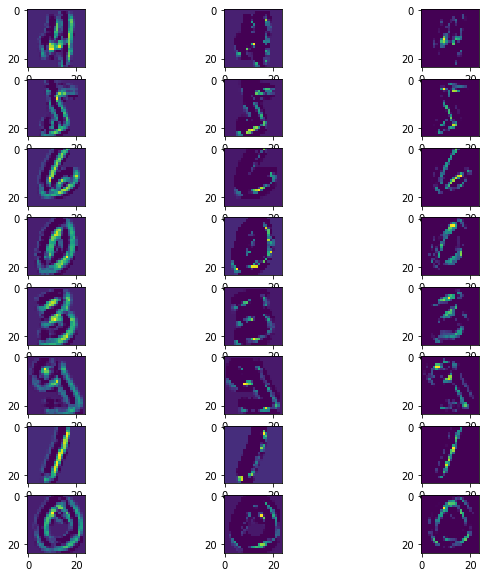

In [14]:
plt.figure(figsize=(10,10))
show_features(net.features_1(images.to(device)).detach().cpu())

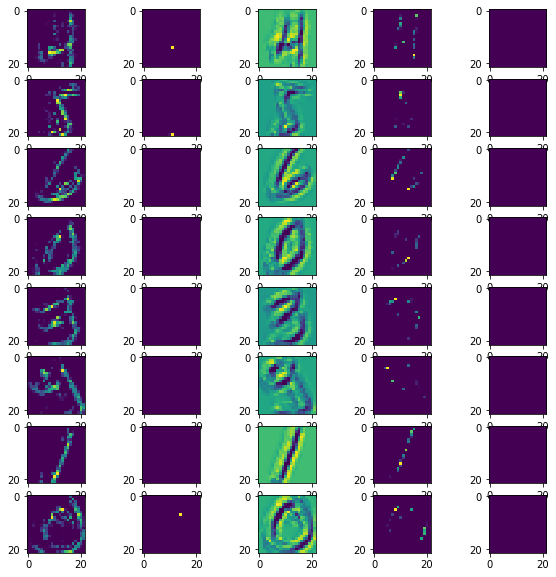

In [15]:
plt.figure(figsize=(10,10))
show_features(net.features_2(images.to(device)).detach().cpu())

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [17]:
from IPython.display import clear_output
epochs = 4
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    
#             clear_output()
            print('Epoch %d, step %5d loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

Epoch 1, step  1000 loss: 2.302
Epoch 1, step  2000 loss: 2.296
Epoch 1, step  3000 loss: 2.282
Epoch 1, step  4000 loss: 2.238
Epoch 1, step  5000 loss: 1.763
Epoch 1, step  6000 loss: 0.608
Epoch 1, step  7000 loss: 0.400
Epoch 2, step  1000 loss: 0.344
Epoch 2, step  2000 loss: 0.307
Epoch 2, step  3000 loss: 0.294
Epoch 2, step  4000 loss: 0.280
Epoch 2, step  5000 loss: 0.265
Epoch 2, step  6000 loss: 0.252
Epoch 2, step  7000 loss: 0.231
Epoch 3, step  1000 loss: 0.199
Epoch 3, step  2000 loss: 0.209
Epoch 3, step  3000 loss: 0.190
Epoch 3, step  4000 loss: 0.186
Epoch 3, step  5000 loss: 0.161
Epoch 3, step  6000 loss: 0.165
Epoch 3, step  7000 loss: 0.153
Epoch 4, step  1000 loss: 0.150
Epoch 4, step  2000 loss: 0.140
Epoch 4, step  3000 loss: 0.135
Epoch 4, step  4000 loss: 0.134
Epoch 4, step  5000 loss: 0.135
Epoch 4, step  6000 loss: 0.134
Epoch 4, step  7000 loss: 0.126
Finished Training


In [18]:
labels

tensor([4, 5, 7, 6, 3, 4, 3, 0])

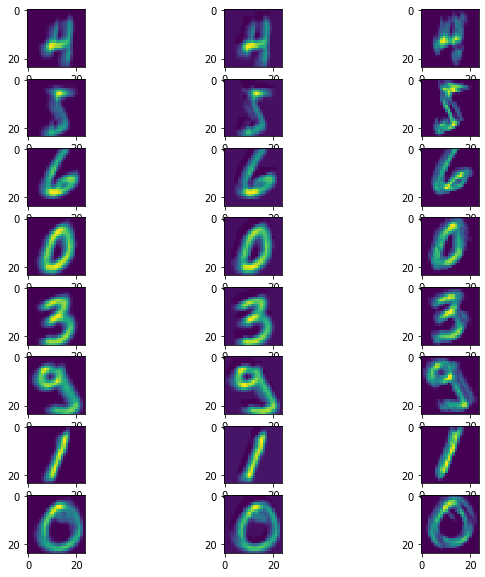

In [19]:
plt.figure(figsize=(10,10))
show_features(net.features_1(images.to(device)).detach().cpu())

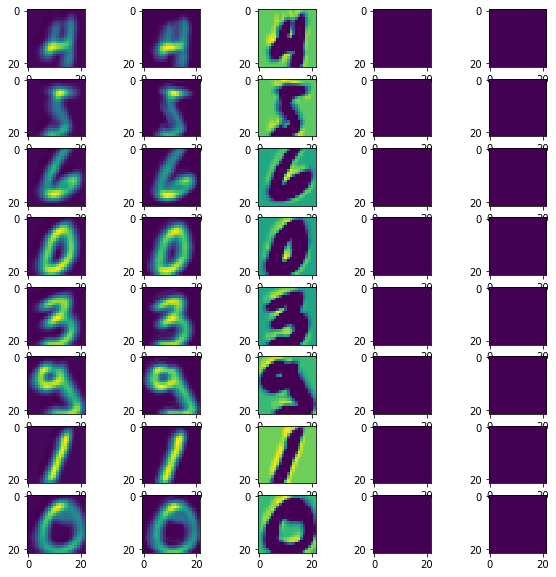

In [20]:
plt.figure(figsize=(10,10))
show_features(net.features_2(images.to(device)).detach().cpu())

GT: tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predict: tensor([7, 2, 1, 0, 4, 1, 4, 9])


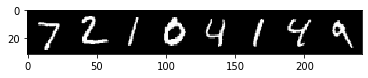

In [21]:
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
plt.imshow(torchvision.utils.make_grid(images.cpu()).numpy().transpose(1,2,0))
print('GT:', labels)
# imshow(images)
print('Predict:', predicted)

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [23]:
errors_inputs = []
errors_labels = []
errors_predicted = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        mask = torch.where(predicted != labels)
        errors_inputs.extend(inputs[mask])
        errors_labels.extend(labels[mask])
        errors_predicted.extend(predicted[mask])

In [24]:
len(errors_inputs)

364

In [30]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=4, 
                               kernel_size=5,
                               padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=4, 
                               out_channels=8, 
                               kernel_size=3, 
                               padding=0)
        
        #fully connected layers
        ## convert matrix with 8*5*5 (= 200) features to a matrix of 120 features (columns)
        self.fc1 = nn.Linear(in_features=8*5*5,
                             out_features=120) 
        self.fc2 = nn.Linear(in_features=120, 
                             out_features=84)
        self.fc3 = nn.Linear(in_features=84, 
                             out_features=10)

    def forward(self, x):
        
        # convolve, then perform ReLU non-linearity
        # max-pooling with 2x2 grid 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        # flattening convolutional layer
        x = x.view(-1, 8 * 5 * 5)
        
        # fully-connected layers + perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def features_2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def features_1(self, x):
        x = F.relu(self.conv1(x))
        return x

In [31]:
model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
def plot_err(idx):
    x = np.arange(0, 10, step=1)
    p = net.forward(errors_inputs[idx].unsqueeze(0))
    p = torch.softmax(p, dim = 1)
    p = p.cpu().data.numpy().squeeze()
    
    print("%d предсказано как %d" % (errors_labels[idx], errors_predicted[idx]))
    plt.figure(figsize=(4,4))
    plt.imshow(errors_inputs[idx].resize_(1,28,28).cpu().numpy().squeeze(), cmap = 'gray')
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.bar(x, p)
    plt.xticks(x)
    plt.ylim(0, 1)
    plt.ylabel('probability')
    plt.xlabel('labels')
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_1(errors_inputs[idx].unsqueeze(0).to(device)).detach().cpu())
    plt.show()
    
    plt.figure(figsize=(16,14))
    show_features(model.features_2(errors_inputs[idx].unsqueeze(0).to(device)).detach().cpu())
    plt.show()

5 предсказано как 6


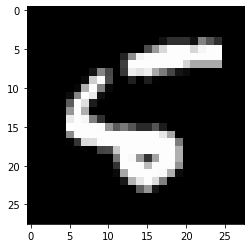

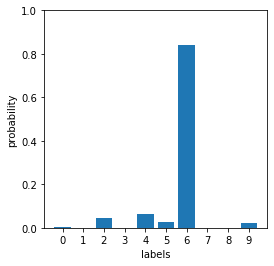

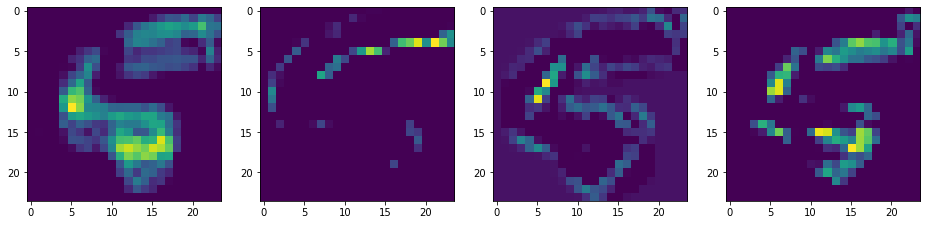

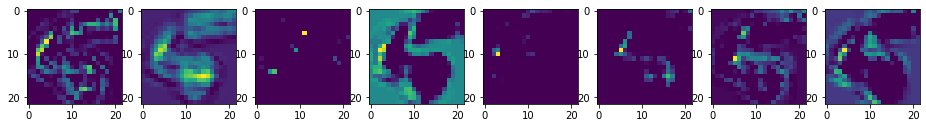

4 предсказано как 2


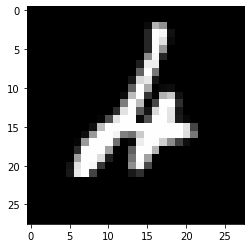

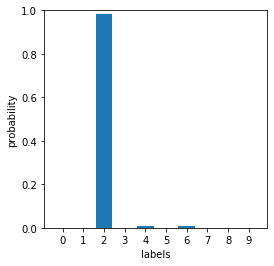

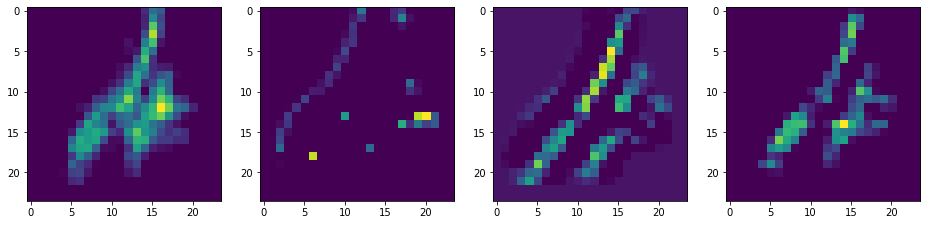

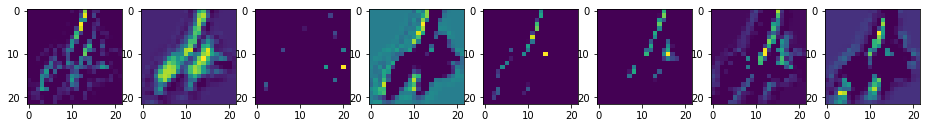

6 предсказано как 0


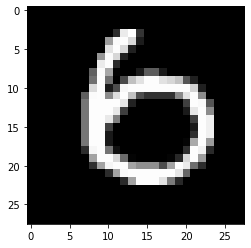

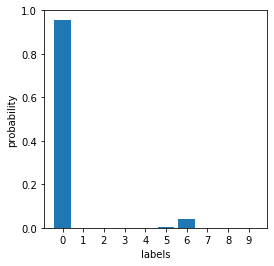

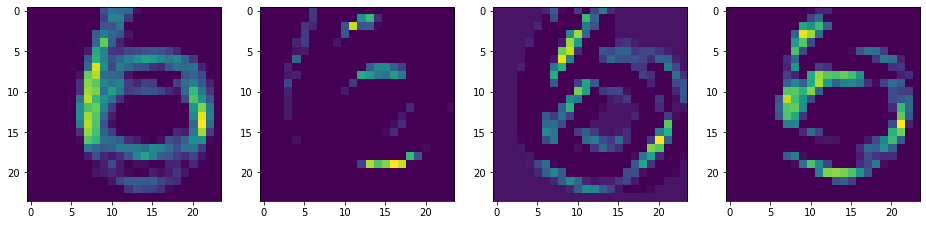

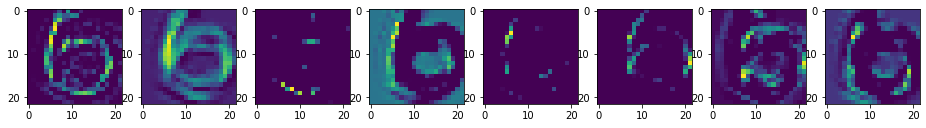

8 предсказано как 4


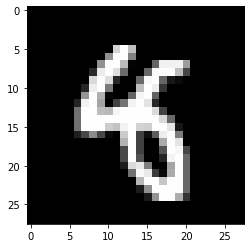

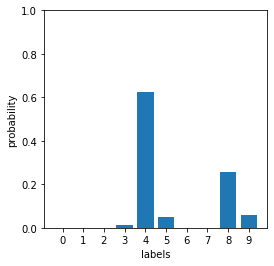

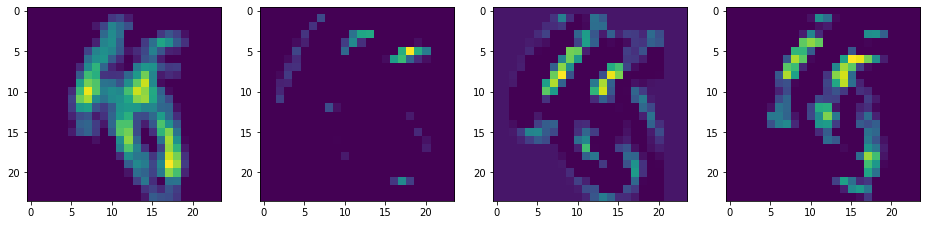

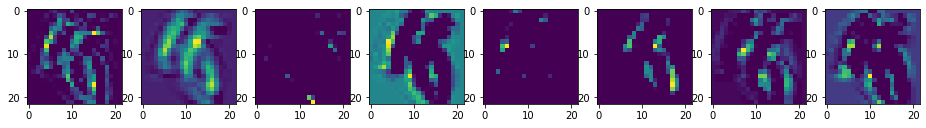

9 предсказано как 7


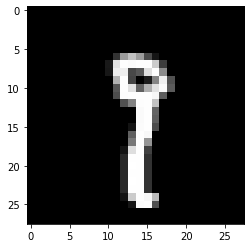

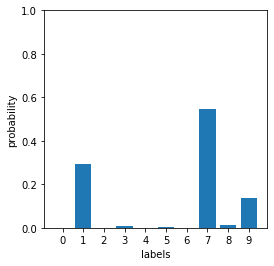

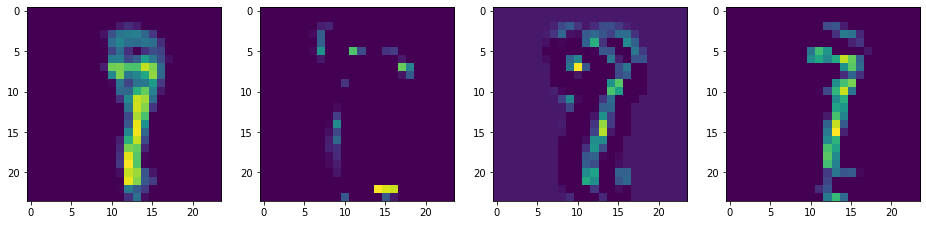

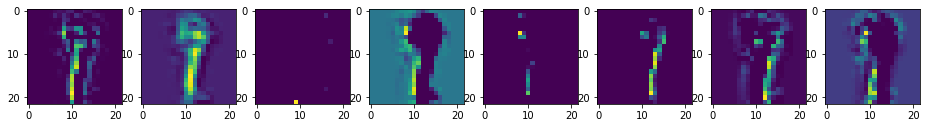

2 предсказано как 7


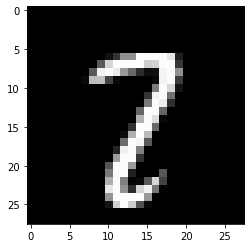

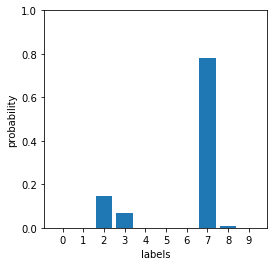

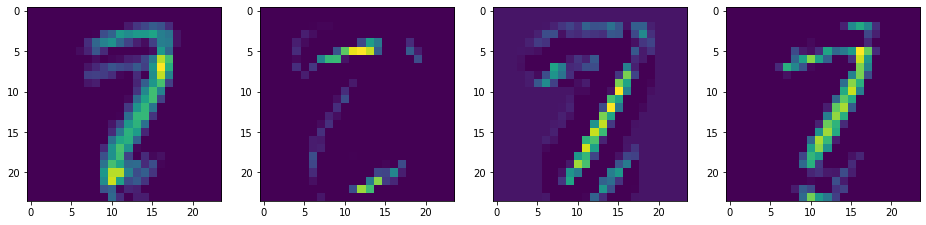

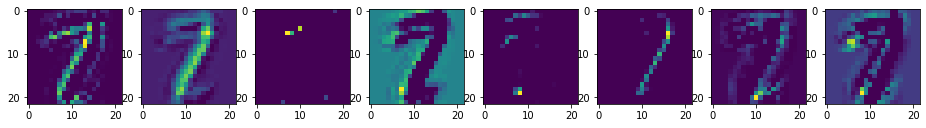

5 предсказано как 3


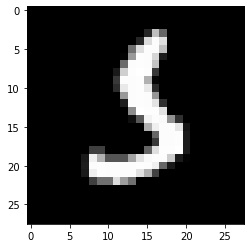

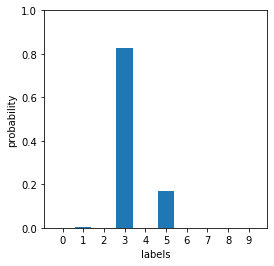

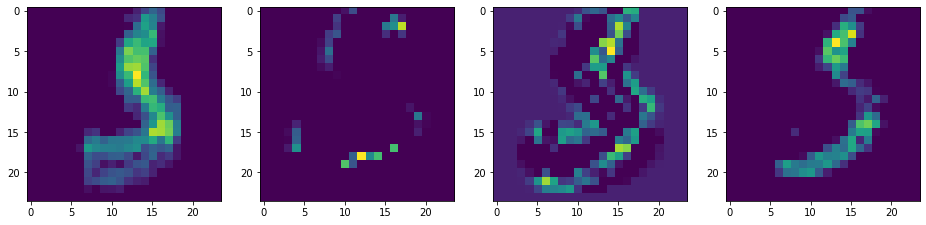

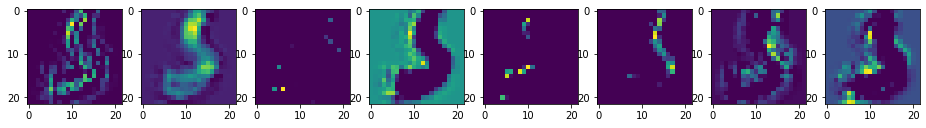

8 предсказано как 2


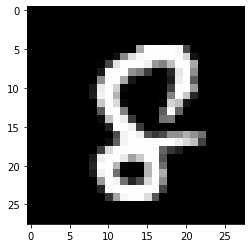

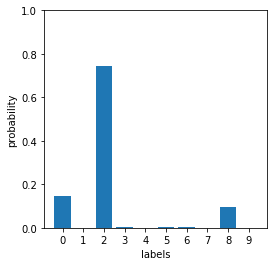

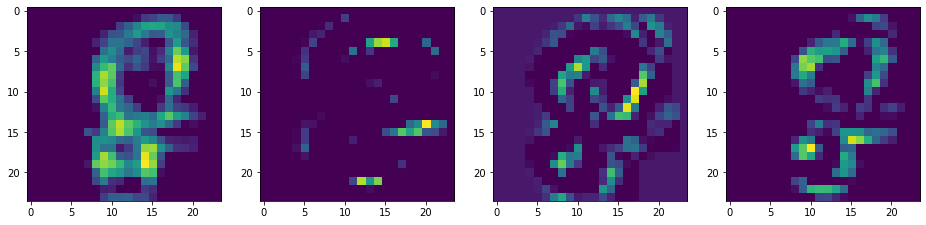

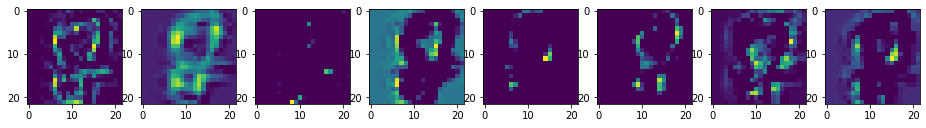

6 предсказано как 0


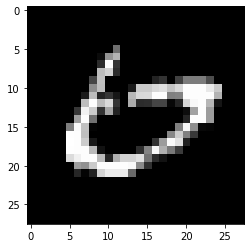

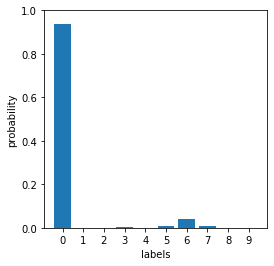

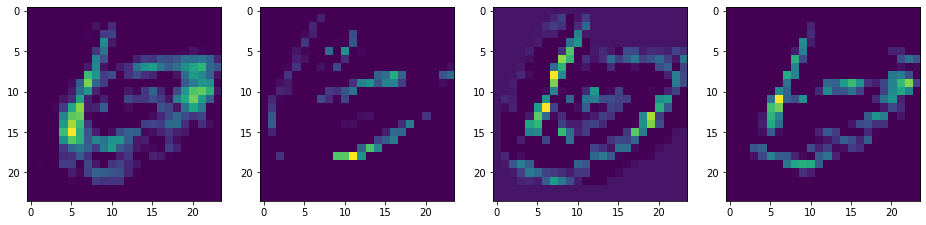

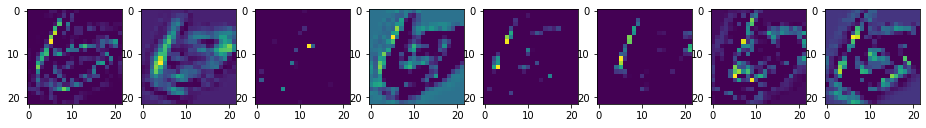

4 предсказано как 9


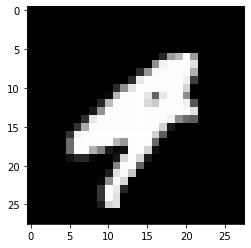

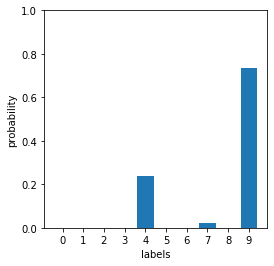

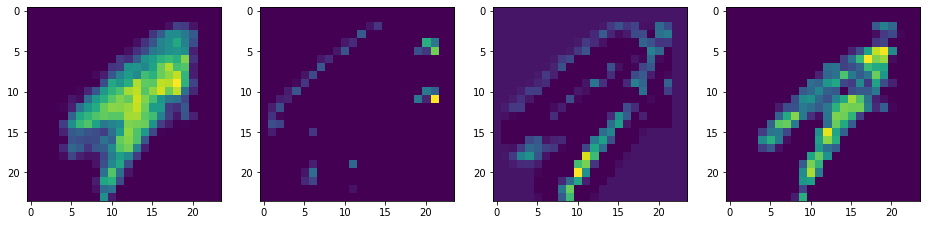

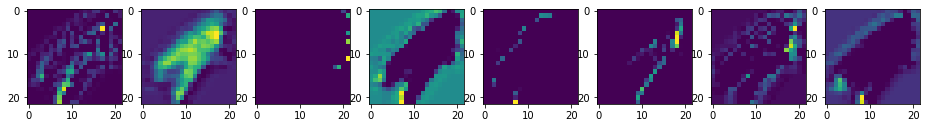

In [34]:
for i in range (10):
    plot_err(i)